# Building Bayesian Networks

by Emil Vassev
<br>
March 7th, 2022

In this notebook, you can follow an example of creating a Bayesian Network, by using the <b>pgmpy</b> Python library. The example tackled by this notebook is the <i>Bayesian Network for Computer Failure</i>, which we covered in detail in our lectures.

Bayesian Network is composed of two components:
<ol>
<li>a directed acyclic graph DAG: 𝓖(𝑉,𝐸)  - nodes  𝑉, and edges 𝐸</li>
<ul>
<li>a set of random variables represented by nodes</li>
<li>directed edges – connect two random variables with causal probabilistic dependency</li>
<li>cycles not allowed in the graph</li>
</ul>
<li>a set of conditional probability distributions</li>
<ul>
<li>conditional probability distribution is defined for each node in the graph</li>
<li>the conditional probability distribution of a node (random variable) is defined for every possible outcome of the preceding causal node(s)</li>
</ul>

## Step 1: Create the DAG of the Bayesian Network

### Step 1.1. Desribe the problem
<ul>
<li>a computer does not start, which is considered as a <b>computer failure</b> (observation/evidence)</li>
<li>possible <i>independent</i> causes of failure:</li>
<ol>
<li><b>electricity failure</b></li> 
<li><b>computer malfunction</b></li>
</ol><br>
<li><b>electricity failure</b> and <b>computer malfunction</b> are ancestors/parents of <b>computer failure</b></li>
<li>inference objectives:</li>
<ol>    
<li>calculate the prior conditional probability distribution of having a <b>computer failure</b> without any evidence</li>
<li>calculate the prior conditional probability distribution of having a <b>computer failure</b> considering a recent <b>electricity failure</b> as evidence</li>
<li>calculate the posterior conditional probability distribution of each of the possible unobserved causes given the observed evidence of a <b>computer failure</b></li>
</ol>
</ul>

### Step 1.2. Draw and show the DAG
Let's show the GAD model from the lectures.

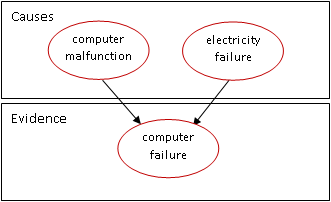

In [1]:
from IPython.display import Image

Image("images/computer_failure.png")

### Step 1.3. Create the DAG of the Bayesian Network by using the pgmpy library
Let's create the Computer Failure Bayesian Network following the DAG shown above. We use the pgmpy library for this task.
<br>
Here, we consider three nodes, each representing a binary random variable:
<ol>
<li><b>electricity_failure</b>: domain = {yes, no}</li> 
<li><b>computer_malfunction</b>: domain = {yes, no}</li>
<li><b>computer_failure</b>: domain = {yes, no}</li>
</ol>

Additional constraints: <b>electricity_failure</b> ⊥ <b>computer_malfunction</b> (independent) 
<br><br>
To build the Bayesian Network DAG we use the BayesianNetwork class provided by the pgmpy library.

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import pylab as plt
 
#**** define the Bayesian DAG structure
#
# we define the Bayesian structure by connecting nodes (random variables)
# the direction is determined from the order of the nodes
#
# here, electricity_failure, computer_malfunction, and computer_failure are random variables

model = BayesianNetwork([('electricity_failure', 'computer_failure'), ('computer_malfunction', 'computer_failure')]) 

### Step 1.4. Show the DAG of the Bayesian Network
We draw the model created in the previous step.

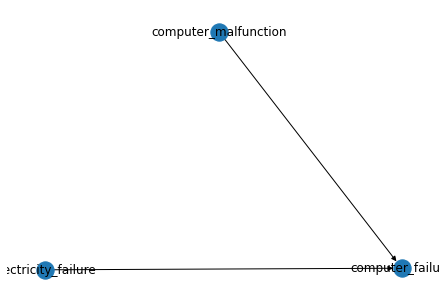

In [3]:
nx.draw(model, with_labels=True)
plt.show()
plt.close()

## Step 2: Create the Conditional Probability Distributions of the Bayesian Network

In this step, we build the distribution models per a random variable. We use our believes and logic to come up with these models. Let's say this is our priori knowledge.

### Step 2.1: Build the probability distribution tables with TabularCPD
In this exercise we are going to use the models provided in the lectures:

<ul>
<li>P (electricity_failure=yes) = 0.1; P (electricity_failure=no) = 0.9</li>
<li>P (computer_malfunction=yes) = 0.2; P (computer_malfunction=no) = 0.8</li>
<li>P (computer_failure=yes | electricity_failure=no ∩ computer_malfunction=no) = 0</li>
<li>P (computer_failure=yes | electricity_failure=no ∩ computer_malfunction=yes) = 0.5</li> 
<li>P (computer_failure=yes | electricity_failure=yes ∩ computer_malfunction=no) = 1</li>
<li>P (computer_failure=yes | electricity_failure=yes ∩ computer_malfunction=yes) = 1</li>
</ul>

We use the TabularCPD class provided by the pgmpy library to build the distribution model of each random variable.

In [4]:
#**** define the Conditional Probability Distributions (CPDs)

# define CPD for electricity_failure
#
# the TabularCPD class associates the ditribution model to be constructed with a random variable, 
# e.g., electricity_failure  
cpd_electricity_failure = TabularCPD (
    # associate the distribution table with a random variable - must be included in the Bayesian model
    variable="electricity_failure",

    # define the cardinality of the variable domain, i.e., binary = 2 -> domain = {yes, no} 
    variable_card=2,
    
    # define the distribution table 
    # values are ordered following the domain {yes, no}
    # e.g., P (electricity_failure=yes) = 0.1; P (electricity_failure=no) = 0.9 
    values=[[0.1], [0.9]] 
)    

# define CPD for computer_malfunction
cpd_computer_malfunction = TabularCPD (
    variable="computer_malfunction",
    variable_card=2,
    values=[[0.2], [0.8]]
)    

# define CPD for computer_failure
cpd_computer_failure = TabularCPD (
    variable="computer_failure",
    variable_card=2,

    # define the distribution table 
    # 
    # this distrbution table includes values for all the combinations of the values 
    # held by the variables that condition this variable
    #
    # electricity_failure = A, computer_malfunction = B, computer_failure = C
    # C=yes = {[A=yes,B=yes],[A=yes,B=no],[A=no,B=yes],[A=no,B=no]} = {1, 1, 0.5, 0} 
    # C=no = {[A=yes,B=yes],[A=yes,B=no],[A=no,B=yes],[A=no,B=no]} = {0, 0, 0.5, 1]}
    # C=yes + C=no = 1 
    #    
    values=[[1, 1, 0.5, 0],[0, 0, 0.5, 1]],

    # define the evidences - one of the causes must be true 
    evidence=["electricity_failure", "computer_malfunction"],
    evidence_card=[2,2]
) 
 


### Step 2.2: Associate the distribution models with the network structure

In [5]:
# we associate the distribution models with the network structure, i.e., with the random variables
model.add_cpds(cpd_electricity_failure, cpd_computer_malfunction, cpd_computer_failure)

### Step 2.3: Check the model
We use the built-in mechanism (the check_model() method) of the BayesianNetwork class to check the distribution models. The following checks are performed:
<ol>
<li>consistency in terms of domain cardinality vs. number of values</li>
<li>Gaussian distribution for values of the same series, e.g., P(no) + P(yes) = 1</li>
</ol>

In [6]:
model.check_model()

True

## Step 3: Inference with the Bayesian Network
In this step, we use the inference mechanisms of the Bayesian Network to: 
<ol>    
<li>calculate the prior conditional probability distribution of having a <b>computer failure</b> without any evidence</li>
<li>calculate the prior conditional probability distribution of having a <b>computer failure</b> considering a recent <b>electricity failure</b> as an evidence</li>
<li>calculate the posterior conditional probability distribution of each of the possible unobserved causes given the observed evidence of a <b>computer failure</b></li>
</ol>
To run inference tasks on this network, we use the VariableElimination class provided by the pgmpy.inference iibrary.

In [7]:
from pgmpy.inference import VariableElimination
 
infer = VariableElimination(model)

### Step 3.1: Infer Posterior Probability of having electricity failure

Recall that we use the Bayes' Theorem to calculate posterior probability. 

<pre>

                            P(Evidence|Cause) * P(Cause)
   P(Cause|Evidence) = ---------------------------------------
		                         P(Evidence) 
                                 
</pre>
<br>
Please, refer to lectures on how we infer posterior probability.

In [8]:
#**** infer posterior probability
# evidence={'computer_failure': 0} means computer_failure = yes
#
posterior_p = infer.query(['electricity_failure'], evidence={'computer_failure': 0})

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Show the posterior probability results.

In [9]:
print(posterior_p)

+------------------------+----------------------------+
| electricity_failure    |   phi(electricity_failure) |
+========================+============================+
| electricity_failure(0) |                     0.5263 |
+------------------------+----------------------------+
| electricity_failure(1) |                     0.4737 |
+------------------------+----------------------------+


### Step 3.2: Infer Prior Probability of having computer failure with no evidence
Recall that we use the following formula to infer prior probability.
<pre>
𝑷(𝒄𝟏)=∑(𝒂∈𝑨)∑(𝒃∈𝑩) 〖𝑷(𝑨=𝒂∩𝑩=𝒃∩𝑪=𝒄𝟏)〗
</pre>
Please, refer to lectures on how we infer posterior probability.

In [10]:
prior_p = infer.query(['computer_failure'], evidence={})

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Show the prior probability results.

In [11]:
print(prior_p)

+---------------------+-------------------------+
| computer_failure    |   phi(computer_failure) |
+=====================+=========================+
| computer_failure(0) |                  0.1900 |
+---------------------+-------------------------+
| computer_failure(1) |                  0.8100 |
+---------------------+-------------------------+


### Step 3.3: Infer Prior Probability of having computer failure with electricity failure as a prior evidence 

In [12]:
prior_p = infer.query(['computer_failure'], evidence={'electricity_failure': 0, 'computer_malfunction': 1})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Show the prior probability results.

In [13]:
print(prior_p)

+---------------------+-------------------------+
| computer_failure    |   phi(computer_failure) |
+=====================+=========================+
| computer_failure(0) |                  1.0000 |
+---------------------+-------------------------+
| computer_failure(1) |                  0.0000 |
+---------------------+-------------------------+
